<picture>
  <!--Imagem para o tema dark-->
  <source media="(prefers-color-scheme: dark)" srcset="https://github.com/CatarinaAguiar3/Projeto_Sistema_de_Recomendacao_MovieLens/blob/main/Imagens/Banners/Dark_Titulo3_Analise_Descritiva.png?raw=true">
  
  <!--Imagem para o tema light-->
  <source media="(prefers-color-scheme: light)" srcset="https://github.com/CatarinaAguiar3/Projeto_Sistema_de_Recomendacao_MovieLens/blob/main/Imagens/Banners/Titulo3_Analise_Descritiva_v2.png?raw=true">

  <!--Imagem padrão (quando os temas dark e light não forem identificados -->
  <img src="https://github.com/CatarinaAguiar3/Projeto_Sistema_de_Recomendacao_MovieLens/blob/main/Imagens/Banners/Titulo3_Analise_Descritiva_v2.png?raw=true">
</picture>

In [ ]:
%load_ext pretty_jupyter

# **Importar Bibliotecas**

In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
# Worcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
# Gráficos
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.subplots as sp
import plotly.express as px

# Salvar o gráfico como um arquivo HTML
import plotly.io as pio


In [4]:
# Calcular a correlação
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [5]:
import numpy as np
import statsmodels.api as sm

In [7]:
# tabset
import jinja2
get_ipython().run_line_magic('load_ext', 'pretty_jupyter')

In [51]:
import json
import pandas as pd
from IPython.display import display, HTML

# **Definir Diretório**

In [6]:
os.chdir("C:/0.Projetos/5.Sistema_de_Recomendacao_MovieLens_2")

# **Carregar Arquivos**

In [8]:
genome_treino= pd.read_pickle("C:/0.Projetos/5.Sistema_de_Recomendacao_MovieLens_2/Datasets/3.Datasets_Transformação/3.2_Datasets_Transformação_parte_2/genome_treino.pickle", compression='gzip')

In [9]:
genome_treino.head(3)

movieId  tagId  relevance           tag
0        1      1    0.03200           007
1        1      2    0.02225  007 (series)
2        1      3    0.07000  18th century

In [10]:
tags_treino = pd.read_pickle("C:/0.Projetos/5.Sistema_de_Recomendacao_MovieLens_2/Datasets/2.Datasets_Limpeza/tags_treino.pickle", compression = "gzip")

In [11]:
tags_treino

userId  movieId           tag   timestamp
0         134    89898   advertising  1521614243
1         134    89898         drugs  1521614238
2         134    89898        Russia  1521614240
3         134   182899        Action  1514209025
4         134   182899          Asia  1514209050
...       ...      ...           ...         ...
44612  330008    79091         nerds  1433358037
44613  330008    79091  supervillain  1433358009
44614  330008    81564     animation  1433357978
44615  330008    81564         funny  1433357989
44616  330008    81564  supervillain  1433357964

[44617 rows x 4 columns]

In [12]:
ratings_treino_transformado = pd.read_pickle("C:/0.Projetos/5.Sistema_de_Recomendacao_MovieLens_2/Datasets/3.Datasets_Transformação/3.1_Datasets_Transformação_parte_1/ratings_treino_transformado.pickle", compression = "gzip")

In [13]:
ratings_treino_transformado.head(3)

userId  Numero_de_Avaliacoes_por_usuarios  movieId  \
0       5                                 43       47   
1     461                               1692       47   
2     751                                469       47   

   Numero_de_Avaliacoes_por_Filme  rating  rating_medio_simples  \
0                            1567     5.0              4.057754   
1                            1567     4.5              4.057754   
2                            1567     3.0              4.057754   

   rating_medio_ponderado  
0                3.286254  
1                3.286254  
2                3.286254

In [14]:
movies_treino_transformado = pd.read_pickle("C:/0.Projetos/5.Sistema_de_Recomendacao_MovieLens_2/Datasets/3.Datasets_Transformação/3.2_Datasets_Transformação_parte_2/movies_treino_transformado.pickle", compression = 'gzip')

In [15]:
movies_treino_transformado.head(3) 

movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  Ano_do_filme  \
0  Adventure|Animation|Children|Comedy|Fantasy          1995   
1                   Adventure|Children|Fantasy          1995   
2                               Comedy|Romance          1995   

     titulo_sem_ano genres_separado  
0         Toy Story       Adventure  
1           Jumanji       Adventure  
2  Grumpier Old Men          Comedy

# **Funções**

## Função 1: Calcula o Resumo Estatístico

In [16]:
def resumo_estatistico(tabela:pd.DataFrame, coluna:str) -> pd.DataFrame:

    # Calcula estatísticas descritivas usando agg
    resumo = tabela[coluna].agg(['count', 'mean','median', 'std', 'min', 'max' ]).round(2)

    # Renomeiar a coluna 'median' para 'median (50%)'
    resumo = resumo.rename(index={'median': 'median (50%)'})

    # Calcula percentis usando quantile
    percentis = tabela[coluna].quantile([0.25, 0.5, 0.75]).round(2)

    # Combina os resultados em um DataFrame único
    resumo = pd.concat([resumo, percentis.rename({0.25: '25%', 0.5: '50%', 0.75: '75%'})])

    display(resumo)

## Função 2: Retorna a frequência e proporção dos valores únicos

In [17]:
def valores_unicos(tabela:pd.DataFrame, coluna:str) -> pd.DataFrame:
    
    # Calcula a contagem dos valores únicos usando value_counts
    contagem = tabela[coluna].value_counts().reset_index()

    # Renomeia as colunas para tornar o resultado mais claro
    contagem.columns = ['Valor_Único', 'Frequência']

    # Adiciona uma coluna de proporção em porcentagem
    contagem['Proporção (%)'] = (contagem['Frequência'] / contagem['Frequência'].sum()) * 100

    # Arredonda a coluna de proporção para 4 casas decimais
    contagem['Proporção (%)'] = contagem['Proporção (%)'].round(4)

    # Formata a coluna de proporção como porcentagem
    contagem['Proporção (%)'] = contagem['Proporção (%)'].map('{:.4f}%'.format)


    return contagem

# **1. Quantidade de usuários, de filmes e de gêneros**
Nesta amostra, existem 7.943 clientes, 24.345 filmes e 19 gêneros de filmes.  

In [18]:
quantidade_user = ratings_treino_transformado['userId'].nunique()
quantidade_filmes = ratings_treino_transformado['movieId'].nunique()
quantidade_generos = movies_treino_transformado['genres_separado'].nunique()

In [19]:
print(f"Quantidade de usuários: {quantidade_user} ")
print(f"Quantidade de filmes: {quantidade_filmes} ")
print(f"Quantidade de genero: {quantidade_generos} ")

Quantidade de usuários: 7943 
Quantidade de filmes: 24345 
Quantidade de genero: 19 


## Gráfico: usuários, filmes e gêneros

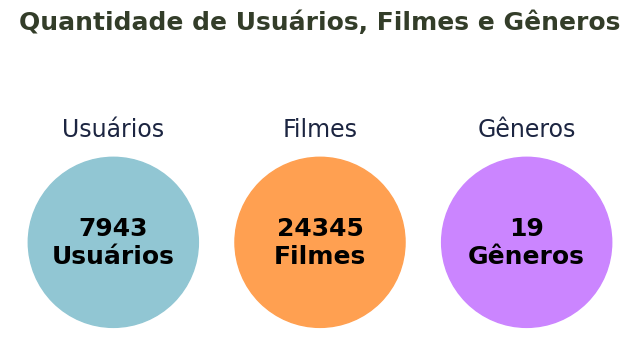

In [20]:
# Criação do gráfico
plt.figure(figsize=(8, 4))

# Definição das posições dos pontos
x_positions = [0.5, 1.5, 2.5]
y_positions = [1, 1, 1]

# Definição das cores dos pontos
#colors = ['#06837f', 'orange'ou '#ffc675', '#6a0572']
#colors = ['#96c9c2','#ffc675' , '#b978b0']
colors = ['#91C6D3','#FFA051' , '#CB85FF']
# Definição dos tamanhos dos pontos
sizes = [15000, 15000, 15000]

# Criação dos pontos no gráfico
plt.scatter(x=x_positions, y=y_positions, s=sizes, color=colors)

# Definição dos limites dos eixos
plt.xlim(0, 3)
plt.ylim(0.9, 1.2)

# Adição de títulos e rótulos
plt.title('Quantidade de Usuários, Filmes e Gêneros', fontsize=18, weight=600, color='#333d29')
plt.text(0.5, 1, f'{quantidade_user}\nUsuários', va='center', ha='center', fontsize=18, weight=600, color='black')
plt.text(1.5, 1, f'{quantidade_filmes}\nFilmes', va='center', ha='center', fontsize=18, weight=600, color='black')
plt.text(2.5, 1, f'{quantidade_generos}\nGêneros', va='center', ha='center', fontsize=18, weight=600, color='black')
plt.text(0.5, 1.11, 'Usuários', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plt.text(1.5, 1.11, 'Filmes', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plt.text(2.5, 1.11, 'Gêneros', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')

# Desliga a exibição dos eixos
plt.axis('off')

# Exibição do gráfico
plt.show()

# **2. Distribuição estatística de Ratings**
A média de ratings é 3,52 e as notas mais dadas são 4, 3, 5 e 3.5 respectivamente. Estes valores mostram que os filmes tem uma avaliação intermediária.

### Resumo Estatístico de Ratings

In [21]:
resumo_estatistico(ratings_treino_transformado, 'rating')

count           820508.00
mean                 3.52
median (50%)         3.50
std                  1.07
min                  0.50
max                  5.00
25%                  3.00
50%                  3.50
75%                  4.00
Name: rating, dtype: float64

### Proporção dos Valores únicos de Ratings

In [22]:
valores_unicos(ratings_treino_transformado, 'rating')

Valor_Único  Frequência Proporção (%)
0          4.0      213944      26.0746%
1          3.0      156350      19.0553%
2          5.0      114835      13.9956%
3          3.5      107438      13.0941%
4          4.5       75437       9.1939%
5          2.0       54051       6.5875%
6          2.5       43567       5.3098%
7          1.0       24483       2.9839%
8          0.5       15507       1.8899%
9          1.5       14896       1.8155%

### Gráfico BoxPlot - Distribuição Rating

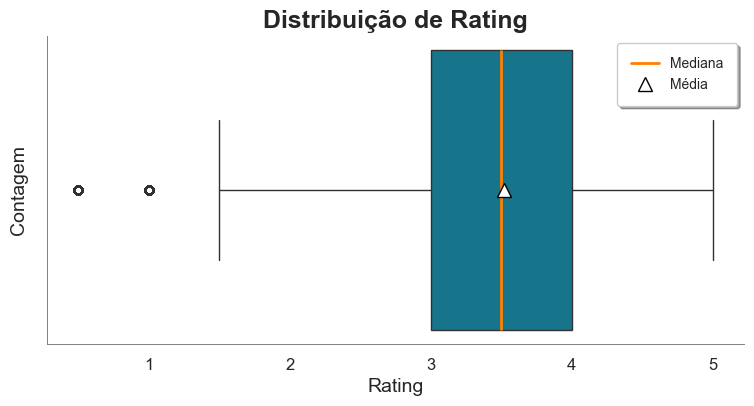

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ajustar o estilo e a paleta de cores
sns.set(style="white", palette="muted")

# Ajustar a escala para melhor visualização
plt.figure(figsize=(9, 4))

# Criar o boxplot
ax = sns.boxplot(x=ratings_treino_transformado['rating'], 
                 color="#04819E",
                 medianprops={"color": "#FF7F00", "linewidth": 2},
                 showmeans=True,
                 meanprops={"markerfacecolor":"white", 
                            "markeredgecolor":"black",
                            "markersize":"10"})

# Adicionar legendas manuais
plt.plot([], [], color='#FF7F00', label='Mediana', linewidth=2)
plt.plot([], [], 'w^', label='Média', markersize=10, markeredgecolor="black")

# Adicionar título e rótulos aos eixos
plt.title('Distribuição de Rating', fontsize=18, fontweight='bold')
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Contagem', fontsize=14)

# Exibir a legenda à esquerda
plt.legend(loc='upper right', fontsize=10, frameon=True, fancybox=True, shadow=True, borderpad=1)

# Ajustar a cor das bordas esquerda e direita
ax.spines['bottom'].set_color('#808080')  # definir a cor desejada para a borda esquerda
ax.spines['left'].set_color('#808080')  # definir a cor desejada para a borda direita
ax.spines['bottom'].set_linewidth(0.7)  # ajustar a largura da borda esquerda
ax.spines['left'].set_linewidth(0.7)  # ajustar a largura da borda direita

# Remover as bordas de cima e da direita
sns.despine(top=True, right=True)

# Ajustar os ticks dos eixos
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Exibir o gráfico
plt.show()


### Gráfico- Contagem de valores de Rating

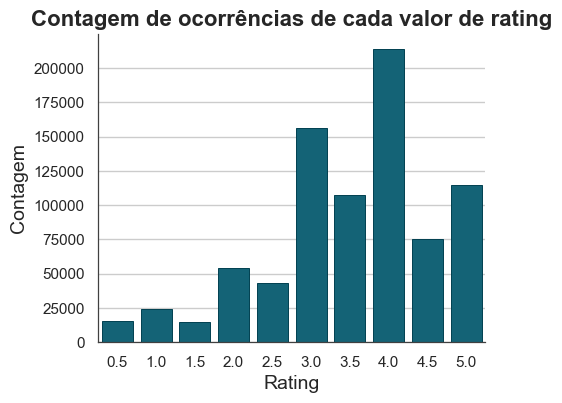

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criar um gráfico de contagem para a coluna ratings
plt.figure(figsize=(5, 4))
sns.set(style="whitegrid")
ax = sns.countplot(x=ratings_treino_transformado['rating'], color="#046D86")

# Adicionar título e rótulos aos eixos
plt.title('Contagem de ocorrências de cada valor de rating', fontsize=16, fontweight='bold')
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Contagem', fontsize=14)

# Ajustar a cor das bordas
ax.spines['bottom'].set_color('#404040')
ax.spines['left'].set_color('#404040')

# Ajustar a largura das bordas 
ax.spines['bottom'].set_linewidth(0.9)
ax.spines['left'].set_linewidth(0.9)

# Adicionar bordas às barras
for patch in ax.patches:
    patch.set_edgecolor('#004050')  # cor da borda
    patch.set_linewidth(0.7)        # espessura da borda

# Remover as bordas de cima e da direita
sns.despine(top=True, right=True)

# Exibir o gráfico
plt.show()


# **3.Quantidade de filmes que um usuário avalia**
Um usuário avalia em média 609 filmes e a mediana é 318. A maioria dos usuários faz 15 avaliações, seguidos de usuários que fazem 5.071 , 4.228, 4.135 e 16 avaliações, respectivamente. 
<br><br>
Pensamos em duas hipóteses sobre os usuários que fazem 15 avaliações: <br>
$H_0:$ Os usuários são novos no site, por isso, fizeram poucas avaliações. <br>
$H_1:$ Os usuários utilizaram o site por um tempo e não ficaram satisfeitos. Por isso, deixaram de usá-lo. 
<br><br>
Para entender qual é a hipótese mais provável, fizemos uma análise gráfica do número de avaliações por usuário e da média de ratings. Ao olhar o histograma, observa-se que a maioria das avaliações por usuários fica entre 0 e 1.000. <br>
Por isso, criamos um outro gráfico cujo intervalo fica entre 0 e 1.000. E notamos que a partir de 40 avaliações por usuário, a contagem começa a diminuir. 
<br><br>
Em relação a ratings, separamos o dataset em faixas e examinamos a média desta coluna. O que observamos é que , em média, ratings diminui conforme o número de avaliações aumenta. 

> $\uparrow$ Contagem do Número de Avaliações por usuário  $\ \ \ \ $ $\downarrow$  Nota dada (rating)

Isto pode ser resultado de uma insatisfação dos usuários com as recomendações $(H_1)$.


In [25]:
ratings_treino_transformado.head()

userId  Numero_de_Avaliacoes_por_usuarios  movieId  \
0       5                                 43       47   
1     461                               1692       47   
2     751                                469       47   
3     974                               1160       47   
4    1174                                 12       47   

   Numero_de_Avaliacoes_por_Filme  rating  rating_medio_simples  \
0                            1567     5.0              4.057754   
1                            1567     4.5              4.057754   
2                            1567     3.0              4.057754   
3                            1567     5.0              4.057754   
4                            1567     5.0              4.057754   

   rating_medio_ponderado  
0                3.286254  
1                3.286254  
2                3.286254  
3                3.286254  
4                3.286254

### Resumo Estatístico do Nº de Avaliações por Usuários

In [26]:
resumo_estatistico(ratings_treino_transformado,'Numero_de_Avaliacoes_por_usuarios' )

count           820508.00
mean               609.36
median (50%)       318.00
std                821.60
min                  1.00
max               5071.00
25%                122.00
50%                318.00
75%                733.00
Name: Numero_de_Avaliacoes_por_usuarios, dtype: float64

### Rating por faixas 
Separamos a coluna rating em diferentes faixas para identificar se, em média, há alguma relação com o aumento do número de avaliações por usuário. 

In [27]:
filtro_0_40 = ratings_treino_transformado.loc[(ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] <= 40)]
filtro_41_500 = ratings_treino_transformado.loc[
    (ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] >= 40) &
    (ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] <= 500)
]

filtro_501_1000 = ratings_treino_transformado.loc[
    (ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] >= 501) &
    (ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] <= 1000)
]

filtro_1001_1500 = ratings_treino_transformado.loc[
    (ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] >= 1001) &
    (ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] <= 1500)
]

filtro_1501_2000 = ratings_treino_transformado.loc[
    (ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] >= 1501) &
    (ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] <= 2000)
]

filtro_2001_3000 = ratings_treino_transformado.loc[
    (ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] >= 2001) &
    (ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] <= 3000)
]

filtro_3001_4500 = ratings_treino_transformado.loc[
    (ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] >= 3001) &
    (ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] <= 4500)
]

filtro_4501_5071 = ratings_treino_transformado.loc[
    (ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] >= 4501) &
    (ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] <= 5071)
]

In [28]:
faixas = pd.DataFrame({
    'Faixas_Numero_de_avaliacoes':['0-40','41-500', '501-1000', '1001-1500', '1501-2000', '2001-3000', '3001-4500', '4501-5071'],
    'Faixas_Numero_de_avaliacoes2':[40,500, 1000, 1500, 2000,3000,4500, 5071],
    'Rating_por_faixa':[filtro_0_40['rating'].mean(), filtro_41_500['rating'].mean(),filtro_501_1000['rating'].mean(), filtro_1001_1500['rating'].mean(), filtro_1501_2000['rating'].mean(), filtro_2001_3000['rating'].mean(),filtro_3001_4500['rating'].mean(),filtro_4501_5071['rating'].mean()]
})
faixas

Faixas_Numero_de_avaliacoes  Faixas_Numero_de_avaliacoes2  Rating_por_faixa
0                        0-40                            40          3.696145
1                      41-500                           500          3.650309
2                    501-1000                          1000          3.417410
3                   1001-1500                          1500          3.235099
4                   1501-2000                          2000          3.254429
5                   2001-3000                          3000          2.961035
6                   3001-4500                          4500          2.877094
7                   4501-5071                          5071          2.658154

### Gráfico Número de avaliações por usuário e rating

In [123]:
import plotly.graph_objs as go
import plotly.offline as pyo

# Dados para o histograma
histogram_data = ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios']

# Dados para o gráfico de linha
df_linha = faixas

# Criar o gráfico combo com histograma e linha
fig = go.Figure()

# Adicionar histograma
fig.add_trace(go.Histogram(
    x=histogram_data,
    nbinsx=100,
    marker_color="#7D01D6",
    marker_line_color='white',
    marker_line_width=1.5,
    name='Distribuição do número de avaliações de filme por usuário',
    yaxis='y1'  # Associando ao eixo y1 (à esquerda)
))

# Adicionar linha com médias de rating por faixa
fig.add_trace(go.Scatter(
    x=df_linha['Faixas_Numero_de_avaliacoes2'],
    y=df_linha['Rating_por_faixa'],
    mode='lines+markers',
    line=dict(color='#FF5733', width=2.9),
    marker=dict(color='#FF5733', size=9),
    name='Média de Ratings por Faixa de Número de Avaliações por Usuário',
    xaxis='x',
    yaxis='y2'  # Associando ao eixo y2 (à direita)
))

# Atualizar layout do gráfico
fig.update_layout(
    width=950,
    height=550,
    title='Distribuição do número de avaliações de filme por usuário e Média de Ratings por Faixa',
    title_font=dict(size=20, family='Arial', color='black', weight='bold'),  # Tamanho e estilo do título
    xaxis_title='Número de avaliações de filme por usuário',
    yaxis_title='Contagem',
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=500,
        tickfont=dict(size=12),
        fixedrange=True  # Desabilitar zoom no eixo x
    ),
    yaxis=dict(
        title='Contagem',
        side='left',  # Posicionar à esquerda
        showgrid=False,
        showticklabels=True,
        tickfont=dict(size=12),
        fixedrange=True  # Desabilitar zoom no eixo y
    ),
    yaxis2=dict(
        title='Média de Rating',
        overlaying='y',
        side='right',  # Posicionar à direita
        showgrid=False,
        showticklabels=True,
        tickfont=dict(size=12),
        fixedrange=True  # Desabilitar zoom no eixo y2
    ),
    font=dict(family="Arial", size=12),
    legend=dict(
        x=0.5,  # Posição horizontal da legenda em relação ao gráfico
        y=1.05,   # Posição vertical da legenda em relação ao gráfico
        traceorder='normal',
        font=dict(
            family='Arial',
            size=12,
            color='black'
        ),
        bgcolor='rgba(255, 255, 255, 0.5)',
        bordercolor='rgba(0, 0, 0, 0.4)',
        borderwidth=1
    ),
    showlegend=True,
    plot_bgcolor='white',
    # Desabilitar completamente a seleção de caixa e laço
    dragmode=False
)

# Configurar para desativar completamente o menu superior
fig.show(config={'displayModeBar': False}, renderer="notebook_connected")

In [124]:
# Salvar o gráfico como um arquivo HTML
import plotly.io as pio
pio.write_html(fig, file='Distribuicao_Numero_de_avaliacoes_por_usuario.html', auto_open=True, config={'displayModeBar': False})

## Comparar as médias de quem avalia muito e pouco
Vamos analisar a média da coluna rating dos usuários que avaliaram até 1.000 filmes e dos usuários que avaliaram mais de 1.000 filmes.

### Selecionar apenas até 1.000 avaliações por usuário

In [31]:
filtro_1000 = ratings_treino_transformado.loc[(ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] <= 1000)]
filtro_1000.head(3)

userId  Numero_de_Avaliacoes_por_usuarios  movieId  \
0       5                                 43       47   
2     751                                469       47   
4    1174                                 12       47   

   Numero_de_Avaliacoes_por_Filme  rating  rating_medio_simples  \
0                            1567     5.0              4.057754   
2                            1567     3.0              4.057754   
4                            1567     5.0              4.057754   

   rating_medio_ponderado  
0                3.286254  
2                3.286254  
4                3.286254

In [32]:
import pandas as pd

# Definindo os intervalos e rótulos das faixas
faixas_definidas = [
    (0, 40),
    (11, 80),
    (81, 100),
    (101, 150),
    (151, 200),
    (201, 250),
    (251, 300),
    (301, 350),
    (351, 400),
    (401, 550),
    (551, 650),
    (651, 700),
    (701, 800),
    (801, 1000)
]

# Criando uma lista para armazenar os resultados
faixas_data = []

# Iterando sobre os intervalos
for faixa in faixas_definidas:
    faixa_min, faixa_max = faixa
    filtro = ratings_treino_transformado.loc[
        (ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] >= faixa_min) &
        (ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'] <= faixa_max)
    ]
    faixa_label = f'{faixa_min}-{faixa_max}'
    rating_medio = filtro['rating'].mean()
    # Obtendo o último número da faixa
    ultimo_numero = faixa_max
    faixas_data.append({
        'Faixas_Numero_de_avaliacoes': faixa_label,
        'Faixas_Numero_de_avaliacoes2': ultimo_numero,
        'Rating_por_faixa': rating_medio
    })

# Criando o DataFrame a partir da lista de dicionários
faixas1 = pd.DataFrame(faixas_data)

# Exibindo o DataFrame com as faixas, o último número da faixa e as médias de rating
print(faixas1)


   Faixas_Numero_de_avaliacoes  Faixas_Numero_de_avaliacoes2  Rating_por_faixa
0                         0-40                            40          3.696145
1                        11-80                            80          3.729868
2                       81-100                           100          3.747573
3                      101-150                           150          3.722232
4                      151-200                           200          3.678422
5                      201-250                           250          3.679058
6                      251-300                           300          3.576646
7                      301-350                           350          3.585126
8                      351-400                           400          3.559443
9                      401-550                           550          3.447619
10                     551-650                           650          3.466044
11                     651-700                      

In [121]:
# Dados para o histograma
histogram_data = filtro_1000['Numero_de_Avaliacoes_por_usuarios']

# Dados para o grafico de linha
df_linha1 = faixas1

# Criar o gráfico combo com histograma e linha
fig = go.Figure()

# Adicionar histograma
fig.add_trace(go.Histogram(
    x=histogram_data,
    nbinsx=50,
    marker_color="#7D01D6",
    marker_line_color='white',
    marker_line_width=1.5,
    name='Distribuição do número de avaliações de filme por usuário',
    yaxis='y1'  # Associando ao eixo y1 (à esquerda)
))

# Adicionar linha com médias de rating por faixa
fig.add_trace(go.Scatter(
    x=df_linha1['Faixas_Numero_de_avaliacoes2'],
    y=df_linha1['Rating_por_faixa'],
    mode='lines+markers',
    line=dict(color='#FF5733', width=2.9),
    marker=dict(color='#FF5733', size=9),
    name='Média de Ratings por Faixa de Número de Avaliações por Usuário',
    xaxis='x',
    yaxis='y2'  # Associando ao eixo y2 (à direita)
))

# Atualizar layout do gráfico
fig.update_layout(
    width=950,
    height=550,
    title='Distribuição do número de avaliações de filme por usuário e Média de Ratings por Faixa (até 1.000 avaliações)',
    title_font=dict(size=16, family='Arial', color='black', weight='bold'),  # Tamanho e estilo do título
    xaxis_title='Número de avaliações de filme por usuário',
    yaxis_title='Contagem',
     xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=50,
        tickfont=dict(size=12),
        fixedrange=True  # Desabilitar zoom no eixo x
    ),
    yaxis=dict(
        title='Contagem',
        side='left',  # Posicionar à esquerda
        showgrid=False,
        showticklabels=True,
        tickfont=dict(size=12),
        fixedrange=True  # Desabilitar zoom no eixo y
    ),
    yaxis2=dict(
        title='Média de Rating',
        overlaying='y',
        side='right',  # Posicionar à direita
        showgrid=False,
        showticklabels=True,
        tickfont=dict(size=12),
        fixedrange=True  # Desabilitar zoom no eixo y2
    ),
    font=dict(family="Arial", size=12),
    legend=dict(
        x=0.5,  # Posição horizontal da legenda em relação ao gráfico
        y=1.05,   # Posição vertical da legenda em relação ao gráfico
        traceorder='normal',
        font=dict(
            family='Arial',
            size=12,
            color='black'
        ),
        bgcolor='rgba(255, 255, 255, 0.5)',
        bordercolor='rgba(0, 0, 0, 0.4)',
        borderwidth=1
    ),
    showlegend=True,
    plot_bgcolor='white'
)

# Exibir o gráfico
fig.show(config={'displayModeBar': False}, renderer="notebook_connected")

In [122]:
# Salvar o gráfico como um arquivo HTML
import plotly.io as pio
pio.write_html(fig, file='Distribuicao_Numero_de_avaliacoes_por_usuario_ate_1000.html', auto_open=True, config={'displayModeBar': False})

# **4. Existe relação entre o número de avaliações por usuário e a nota dada ?**
<!--Esta análise verifica se existe algum tipo de associação entre as variáveis, porém **sem definir se existe causalidade**<br> 
A correlação entre o nº de avaliações e a nota dada é  **significativa** (p-valor:0),  **positiva** , porém **fraca**. Portanto, há alguma associação entre as variáveis, entretanto ela é baixa.
<br><br>
No gráfico boxplot, utilizamos o rating médio ponderado (agrupado), ao invés do rating dado por cada usuário. Fazer desta forma é uma boa opção, pois cada filme será representado por um único ponto do gráfico. 
<br><br>
Observamos que os menores valores do boxplot e o maior tem uma variabilidade baixa, pois os mínimos e os máximos estão muito próximos.
<br>
A partir do ratings médio ponderado (agrupado) de 1,5 até 3,5, essa variabilidade aumenta. <br>
As caixas que vão de 0 à 3 apresentam outliers. E, também percebemos que conforme o rating médio poderado (agrupado) aumenta, o número de avaliações também aumenta.
<br>
O resultado mostra que existe algum tipo de associção entre as variáveis e isto <b><mark>complementa o resultado da análise do tópico 3</mark></b>. -->
O objetivo desta análise é complementar o tópico 3. O resultado mostra que existe uma relação **negativa** , **fraca**, porém  **significativa** entre a nota dada pelo usuário (rating) e o número de avaliações por usuário. Ou seja, conforme o número de avaliações aumenta, rating dimimui. O resultado destas correlações também é um indicativo de que com o passar do tempo, o usuário fica insatisfeito com as recomendações, dando uma nota menor nas avaliações dos filmes.
<br>
Conforme o resultado anterior, este também sinaliza que a Movilens precisa melhorar as recomendações dos filmes e encontrar maneiras de reter o usuário por mais tempo. <b><mark>Este tipo de análise também poderia ser feita por sites como NetFlix.</mark></b>


In [34]:
# Olhar as primeiras linhas da tabela que será usada
ratings_treino_transformado.head()

userId  Numero_de_Avaliacoes_por_usuarios  movieId  \
0       5                                 43       47   
1     461                               1692       47   
2     751                                469       47   
3     974                               1160       47   
4    1174                                 12       47   

   Numero_de_Avaliacoes_por_Filme  rating  rating_medio_simples  \
0                            1567     5.0              4.057754   
1                            1567     4.5              4.057754   
2                            1567     3.0              4.057754   
3                            1567     5.0              4.057754   
4                            1567     5.0              4.057754   

   rating_medio_ponderado  
0                3.286254  
1                3.286254  
2                3.286254  
3                3.286254  
4                3.286254

## Correlação

### Correlação de Spearman

In [35]:
correlacao_avaliacao1= spearmanr(ratings_treino_transformado['rating'], ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'])
print("Coeficiente de correlação de Spearman:", correlacao_avaliacao1.statistic)
print("Valor-p:", correlacao_avaliacao1.pvalue)

Coeficiente de correlação de Spearman: -0.20686186680073784
Valor-p: 0.0


### Correlação de Pearson

In [36]:
correlacao_avaliacao2 = pearsonr(ratings_treino_transformado['rating'], ratings_treino_transformado['Numero_de_Avaliacoes_por_usuarios'])
print("Coeficiente de correlação de Pearson:", correlacao_avaliacao2.statistic)
print("Valor-p:", correlacao_avaliacao2.pvalue)

Coeficiente de correlação de Pearson: -0.1968693320249229
Valor-p: 0.0


### Gráfico BoxPlot 
Para fazer o gráfico, vamos utilizar o rating médio ponderado e agrupá-lo em intervalos de 0,5. 

In [37]:
# Definindo os intervalos de 0.5 em 0.5 de 0 a 5
bins = np.arange(0, 5.5, 0.5)

# Função para arredondar para o intervalo mais próximo de 0,5
def arredondar(number):
    return round(number * 2) / 2

df = ratings_treino_transformado.copy()
# Aplicando a função ao DataFrame
df['media_ponderada_arredondada'] = df['rating_medio_ponderado'].apply(arredondar)

In [38]:
# Olhar a tabela para ver se deu certo
df.head()

userId  Numero_de_Avaliacoes_por_usuarios  movieId  \
0       5                                 43       47   
1     461                               1692       47   
2     751                                469       47   
3     974                               1160       47   
4    1174                                 12       47   

   Numero_de_Avaliacoes_por_Filme  rating  rating_medio_simples  \
0                            1567     5.0              4.057754   
1                            1567     4.5              4.057754   
2                            1567     3.0              4.057754   
3                            1567     5.0              4.057754   
4                            1567     5.0              4.057754   

   rating_medio_ponderado  media_ponderada_arredondada  
0                3.286254                          3.5  
1                3.286254                          3.5  
2                3.286254                          3.5  
3                3.286254                          3.5  
4                3.286254                          3.5

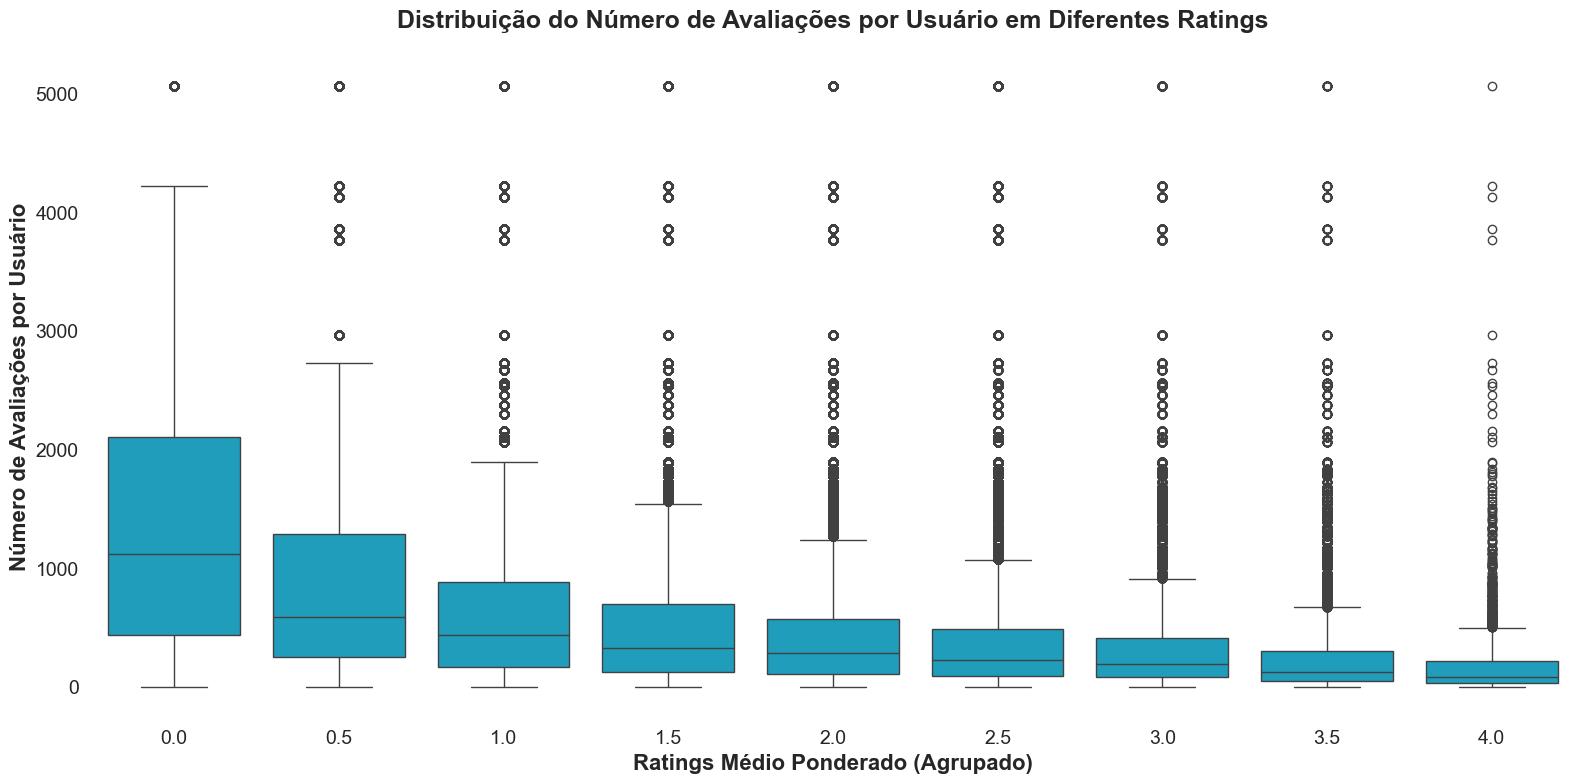

In [39]:
# Definir o estilo e a paleta de cores
sns.set(style="white", palette="pastel")

# Criar o gráfico de dispersão
plt.figure(figsize=(16, 8))
sns.boxplot(x=df['media_ponderada_arredondada'], y=df['Numero_de_Avaliacoes_por_usuarios'], color='#06ADD4')

# Configurações de rótulos e título
plt.ylabel('Número de Avaliações por Usuário', fontsize=16, weight='bold')
plt.xlabel('Ratings Médio Ponderado (Agrupado)', fontsize=16, weight='bold')
plt.title('Distribuição do Número de Avaliações por Usuário em Diferentes Ratings', fontsize=18, weight='bold', pad=20)

# Remover as linhas de grade superior e direita e outras bordas desnecessárias
sns.despine(left=True, bottom=True)

# Ajuste das ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Mostrar o gráfico
plt.show()


# **5. Quais filmes possuem mais avaliações?**

Observa-se que a maioria dos filmes com mais avaliações são do final da década de 90 e início dos anos 2000. O gênero, em sua maioria, é Ação, Comédia e Crime. 
<br>
Os filmes mais avaliados são, respectivamente: The Shawshank Redemption (1994) ; Forrest Gump (1994) e Pulp Fiction (1994).
<br>
Mas ao olhar a nuvem de palavras, vemos outros filmes se destacando: Star Wars, Harry Potter, Batman e Lord of Ring. O que eles tem em comum é que todos tem continuações. Então, se analisarmos as sagas como um todo, esses filmes também são muito avaliados. 

### Olhar as tabelas que serão utilizadas
Vamos utilizar algumas colunas das tabelas `movies_treino_transformado` e `ratings_treino_transformado`.

In [40]:
# Olhar as primeiras linhas da tabela que será ultilizada
movies_treino_transformado.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  Ano_do_filme  \
0  Adventure|Animation|Children|Comedy|Fantasy          1995   
1                   Adventure|Children|Fantasy          1995   
2                               Comedy|Romance          1995   
3                         Comedy|Drama|Romance          1995   
4                                       Comedy          1995   

                titulo_sem_ano genres_separado  
0                    Toy Story       Adventure  
1                      Jumanji       Adventure  
2             Grumpier Old Men          Comedy  
3            Waiting to Exhale          Comedy  
4  Father of the Bride Part II          Comedy

In [41]:
# Olhar as primeiras linhas da tabela que será ultilizada
ratings_treino_transformado.head()

userId  Numero_de_Avaliacoes_por_usuarios  movieId  \
0       5                                 43       47   
1     461                               1692       47   
2     751                                469       47   
3     974                               1160       47   
4    1174                                 12       47   

   Numero_de_Avaliacoes_por_Filme  rating  rating_medio_simples  \
0                            1567     5.0              4.057754   
1                            1567     4.5              4.057754   
2                            1567     3.0              4.057754   
3                            1567     5.0              4.057754   
4                            1567     5.0              4.057754   

   rating_medio_ponderado  
0                3.286254  
1                3.286254  
2                3.286254  
3                3.286254  
4                3.286254

### Selecionar as colunas de interesse
A seguir, selecionaremos as colunas de interesse, para em seguida fazer a união das tabelas.

In [42]:
# Criar uma subtabela de 'movies_genero_separado
tmp_movie = movies_treino_transformado[['movieId', 'title' , 'titulo_sem_ano', 'genres_separado']]
tmp_movie.head(3)

movieId                    title    titulo_sem_ano genres_separado
0        1         Toy Story (1995)         Toy Story       Adventure
1        2           Jumanji (1995)           Jumanji       Adventure
2        3  Grumpier Old Men (1995)  Grumpier Old Men          Comedy

In [43]:
# Criar uma subtabela de 'ratings_data_hora3'
tmp_ratings = ratings_treino_transformado[['movieId','Numero_de_Avaliacoes_por_Filme']]
tmp_ratings.head(3)

movieId  Numero_de_Avaliacoes_por_Filme
0       47                            1567
1       47                            1567
2       47                            1567

### Unir as tabelas
Após selecionar as colunas de interesse, vamos unir estas tabelas. Em seguida, removeremos as linhas duplicadas e organizaremos as tabelas de forma decrescente.  

In [44]:
# Unir as subtabelas
filmes_mais_avaliados1 = pd.merge(tmp_movie , tmp_ratings, on='movieId' , how='right' )
filmes_mais_avaliados1.head(3) 

movieId                        title        titulo_sem_ano genres_separado  \
0       47  Seven (a.k.a. Se7en) (1995)  Seven (a.k.a. Se7en)         Mystery   
1       47  Seven (a.k.a. Se7en) (1995)  Seven (a.k.a. Se7en)         Mystery   
2       47  Seven (a.k.a. Se7en) (1995)  Seven (a.k.a. Se7en)         Mystery   

   Numero_de_Avaliacoes_por_Filme  
0                            1567  
1                            1567  
2                            1567

In [45]:
# Remover as linhas duplicadas
filmes_mais_avaliados2 = filmes_mais_avaliados1.drop_duplicates(subset='title')

# Organizar de forma decrescente
filmes_mais_avaliados3 = filmes_mais_avaliados2.sort_values(by='Numero_de_Avaliacoes_por_Filme', ascending=False)
filmes_mais_avaliados3

movieId                                      title  \
1811        318           Shawshank Redemption, The (1994)   
5454        356                        Forrest Gump (1994)   
41951       296                        Pulp Fiction (1994)   
25480      2571                         Matrix, The (1999)   
11878       593           Silence of the Lambs, The (1991)   
...         ...                                        ...   
811300    27480            Dead or Alive 2: Tôbôsha (2000)   
811301    27549                Dead or Alive: Final (2002)   
787658     6588  And Now... Ladies and Gentlemen... (2002)   
811316    31932                        Fallen Angel (1945)   
820507   165471                            The Ring (1984)   

                            titulo_sem_ano genres_separado  \
1811             Shawshank Redemption, The           Crime   
5454                          Forrest Gump          Comedy   
41951                         Pulp Fiction          Comedy   
25480                          Matrix, The          Action   
11878            Silence of the Lambs, The           Crime   
...                                    ...             ...   
811300            Dead or Alive 2: Tôbôsha          Action   
811301                Dead or Alive: Final          Comedy   
787658  And Now... Ladies and Gentlemen...         Romance   
811316                        Fallen Angel           Crime   
820507                            The Ring           Drama   

        Numero_de_Avaliacoes_por_Filme  
1811                              2948  
5454                              2700  
41951                             2609  
25480                             2578  
11878                             2512  
...                                ...  
811300                               1  
811301                               1  
787658                               1  
811316                               1  
820507                               1  

[24326 rows x 5 columns]

### Tabela com os 10 filmes que possuem mais avaliações
Agora, nós temos a tabela final com os filmes que possuem mais avaliações.

In [46]:
# Selecionar as 30 primeiras linhas
filmes_mais_avaliados4 = filmes_mais_avaliados3.head(10) 
filmes_mais_avaliados4


movieId                                              title  \
1811       318                   Shawshank Redemption, The (1994)   
5454       356                                Forrest Gump (1994)   
41951      296                                Pulp Fiction (1994)   
25480     2571                                 Matrix, The (1999)   
11878      593                   Silence of the Lambs, The (1991)   
39609      260          Star Wars: Episode IV - A New Hope (1977)   
9808       527                            Schindler's List (1993)   
31725     2959                                  Fight Club (1999)   
76326      480                               Jurassic Park (1993)   
48920     1196  Star Wars: Episode V - The Empire Strikes Back...   

                                       titulo_sem_ano genres_separado  \
1811                        Shawshank Redemption, The           Crime   
5454                                     Forrest Gump          Comedy   
41951                                    Pulp Fiction          Comedy   
25480                                     Matrix, The          Action   
11878                       Silence of the Lambs, The           Crime   
39609              Star Wars: Episode IV - A New Hope          Action   
9808                                 Schindler's List           Drama   
31725                                      Fight Club          Action   
76326                                   Jurassic Park          Action   
48920  Star Wars: Episode V - The Empire Strikes Back          Action   

       Numero_de_Avaliacoes_por_Filme  
1811                             2948  
5454                             2700  
41951                            2609  
25480                            2578  
11878                            2512  
39609                            2342  
9808                             2070  
31725                            2049  
76326                            1984  
48920                            1942

### Gráfico com os 10 filmes que possuem mais avaliações

In [113]:
# Converter os dados para JSON
data = [
    {"name": row['title'], "y": row['Numero_de_Avaliacoes_por_Filme']}
    for index, row in filmes_mais_avaliados4.iterrows()
]

# Template HTML com Highcharts
html_template = """
<!DOCTYPE html>
<html>
<head>
    <title>Os 100 filmes com mais avaliações</title>
    <script src="https://code.highcharts.com/highcharts.js"></script>
    <script src="https://code.highcharts.com/highcharts-more.js"></script>
    <script src="https://code.highcharts.com/modules/exporting.js"></script>
    <script src="https://code.highcharts.com/modules/export-data.js"></script>
    <script src="https://code.highcharts.com/modules/accessibility.js"></script>
    <style>
        #container {{
            width: 100%;
            height: 100%;
            max-width: 1000px;
            max-height: 750px;
            margin: 0 auto;
        }}
    </style>
</head>
<body>
    <div id="container"></div>
    <script>
        var data = {data};

        Highcharts.chart('container', {{
            chart: {{
                type: 'bar',
                events: {{
                    load: function () {{
                        var chart = this;
                        setTimeout(function () {{
                            chart.reflow();
                        }}, 0);
                    }}
                }}
            }},
            title: {{
                text: 'Os 10 filmes com mais avaliações',
                align: 'center'
            }},
            xAxis: {{
                categories: {categories},
                title: {{
                    text: 'Título do Filme'
                }},
                labels: {{
                    style: {{
                        fontSize: '14px'
                    }}
                }}
            }},
            yAxis: {{
                min: 0,
                title: {{
                    text: 'Número de Avaliações por Filme',
                    align: 'high'
                }},
                labels: {{
                    enabled: false  // Desabilitar os rótulos do eixo Y (overflow: 'justify' -> para habilitar)
                }}
            }},
            plotOptions: {{
                bar: {{
                    dataLabels: {{
                        enabled: true
                    }},
                    pointWidth: 25  // Ajuste aqui a largura das barras conforme desejado
                }}
            }},
            legend: {{
                enabled: false
            }},
            exporting: {{
                enabled: false
            }},
            credits: {{
                enabled: false
            }},
            series: [{{
                name: 'Número de Avaliações por Filme',
                data: data,
                color: '#046D86'
            }}]
        }});
    </script>
</body>
</html>
""".format(data=json.dumps(data), categories=json.dumps(filmes_mais_avaliados4['title'].tolist()))

# Exibir o gráfico no Jupyter Notebook
display(HTML(html_template))


In [114]:
# Salvar o HTML em um arquivo
with open('filmes_mais_avaliados_v2.html', 'w', encoding='utf-8') as f:
    f.write(html_template)    

<!--<iframe src="https://catarinaaguiar3.github.io/Projeto_Sistema_de_Recomendacao_MovieLens/Imagens/Analise_Descritiva/Q.5/0s_100_filmes_com_mais_avaliacoes.html" width="140%" height="1800px" frameborder="0" scrolling="auto"></iframe>-->

<!--Código responsivo-->
<!--<div style="position: relative; width: 130%; height: 0; padding-bottom: 56.25%;">
    <iframe src="https://catarinaaguiar3.github.io/Projeto_Sistema_de_Recomendacao_MovieLens/Imagens/Analise_Descritiva/Q.5/filmes_mais_avaliados5.html"
            style="position: absolute; top: 0; left: 0; width: 70%; height: 100%; border: 0;"
            frameborder="0" scrolling="auto"></iframe>
</div>-->
<!--<div style="position: relative; width: 100%; height: 80vh; overflow: hidden;">
    <iframe src="https://catarinaaguiar3.github.io/Projeto_Sistema_de_Recomendacao_MovieLens/Imagens/Analise_Descritiva/Q.5/filmes_mais_avaliados5.html"
            style="position: absolute; top: 0; left: 0; width: 100%; height: 100%; border: 0;"
            frameborder="0" scrolling="auto"></iframe>
</div>-->

<div style="position: relative; width: 100%; height: 0; padding-bottom: 56.25%; max-width: 100%; max-height: 100%; overflow: visible;;">
    <iframe src="https://catarinaaguiar3.github.io/Projeto_Sistema_de_Recomendacao_MovieLens/Imagens/Analise_Descritiva/Q.5/filmes_mais_avaliados_v2.html"
            style="position: absolute; top: 0; left: 0; width: 100%; height: 100%; border: 0;"
            frameborder="0" scrolling="yes"></iframe>
</div>

## **Nuvem de palavras 1**
Além do gráfico de barras feito acima, vamos criar 2 nuvens de palavras para representar os filmes mais assitidos. <br>
A Nuvem de palavras 1 contém os 50 filmes mais avaliados.

### Preparar a base 1

In [55]:
# Olhar a tabela criada acima
filmes_mais_avaliados3.head(3)

movieId                             title             titulo_sem_ano  \
1811       318  Shawshank Redemption, The (1994)  Shawshank Redemption, The   
5454       356               Forrest Gump (1994)               Forrest Gump   
41951      296               Pulp Fiction (1994)               Pulp Fiction   

      genres_separado  Numero_de_Avaliacoes_por_Filme  
1811            Crime                            2948  
5454           Comedy                            2700  
41951          Comedy                            2609

In [54]:
# Selecionar os 50 primeiros valores únicos da coluna 'title'
top_50_titulos1 = filmes_mais_avaliados3['titulo_sem_ano'].unique()[:50]

# Filtrr o DataFrame para selecionar as linhas correspondentes aos 50 primeiros valores únicos de 'title'
top_50_titulos2 = filmes_mais_avaliados3[filmes_mais_avaliados3['titulo_sem_ano'].isin(top_50_titulos1) ] 
top_50_titulos2.head()

movieId                             title             titulo_sem_ano  \
1811       318  Shawshank Redemption, The (1994)  Shawshank Redemption, The   
5454       356               Forrest Gump (1994)               Forrest Gump   
41951      296               Pulp Fiction (1994)               Pulp Fiction   
25480     2571                Matrix, The (1999)                Matrix, The   
11878      593  Silence of the Lambs, The (1991)  Silence of the Lambs, The   

      genres_separado  Numero_de_Avaliacoes_por_Filme  
1811            Crime                            2948  
5454           Comedy                            2700  
41951          Comedy                            2609  
25480          Action                            2578  
11878           Crime                            2512

In [56]:
# Concatena todos os títulos em uma única string
todos_titulos = ' '.join(top_50_titulos2['titulo_sem_ano'])

In [57]:
print("Quantidade de palavras:", len(todos_titulos))

Quantidade de palavras: 1130


### Nuvem 1

In [58]:
# Lista de Stopword
stop_words = set(STOPWORDS)

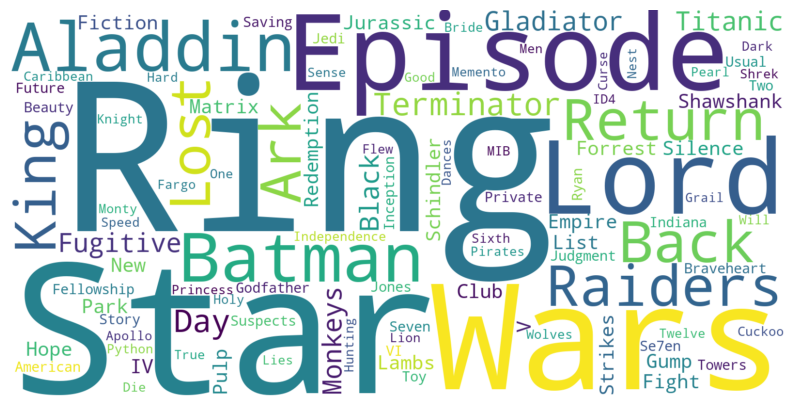

In [59]:
# Gerar a WordCloud
wordcloud_titulo1 = WordCloud(stopwords = stop_words,
                             background_color = 'white' , 
                             width = 1600 , height = 800).generate(todos_titulos)

# Plota a WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_titulo1, interpolation='bilinear')
plt.axis('off')
plt.show()                             

In [ ]:
# Salvar wordcloud 
#wordcloud_titulo.to_file("wordcloud_titulo1.png")

## **Nuvem de palavras 2**
A Nuvem de palavras 2 contém os 300 filmes mais bem avaliados.Vamos utilizar uma máscara para que a nuvem fique com o formato de uma claquete de cinema.

Primeiro, vamos preparar a base selecionando os filmes e concatenando-os em uma úniva string.

In [60]:
# Selecionar os 300 primeiros valores únicos da coluna 'title'
top_300_titulos1 = filmes_mais_avaliados3['titulo_sem_ano'].unique()[:300]

# Filtra o DataFrame para selecionar as linhas correspondentes aos 300 primeiros valores únicos de 'title'
top_300_titulos2 = filmes_mais_avaliados3[filmes_mais_avaliados3['titulo_sem_ano'].isin(top_300_titulos1) ] 
top_300_titulos2.head()

movieId                             title             titulo_sem_ano  \
1811       318  Shawshank Redemption, The (1994)  Shawshank Redemption, The   
5454       356               Forrest Gump (1994)               Forrest Gump   
41951      296               Pulp Fiction (1994)               Pulp Fiction   
25480     2571                Matrix, The (1999)                Matrix, The   
11878      593  Silence of the Lambs, The (1991)  Silence of the Lambs, The   

      genres_separado  Numero_de_Avaliacoes_por_Filme  
1811            Crime                            2948  
5454           Comedy                            2700  
41951          Comedy                            2609  
25480          Action                            2578  
11878           Crime                            2512

In [61]:
# Concatena todos os títulos em uma única string
todos_titulos1 = ' '.join(top_300_titulos2['titulo_sem_ano'])

In [62]:
print(f"Quantidade de palavras: {len(todos_titulos1)} , quantidade de palavras únicas:{len(set(todos_titulos1))}")

Quantidade de palavras: 6106 , quantidade de palavras únicas:74


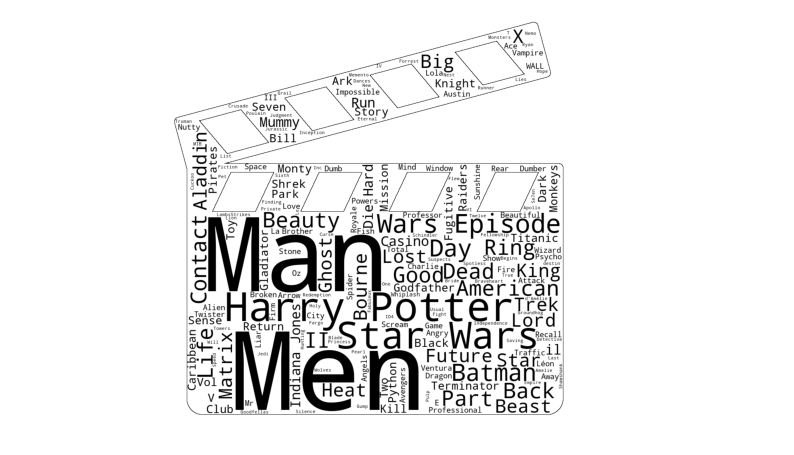

In [65]:
mascara_1 = np.array(Image.open("C:/0.Projetos/5.Sistema_de_Recomendacao_MovieLens_2/Imagens/Análise_Descritiva/Mascaras/mascara_1.png" ))

# Lista de Stopword
stop_words = set(STOPWORDS)
    
# Gerar a word_cloud
wordcloud_titulo4b = WordCloud(stopwords = stop_words,
                             background_color = 'white', 
                             mask = mascara_1,
                             width = 1000 , height = 1000,
                             contour_color='black',
                             contour_width=1,
                             min_font_size= 6,
                             color_func=lambda *args, **kwargs: "black").generate(todos_titulos1)

# Plotar a WordCloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_titulo4b)
plt.axis('off')
plt.show()

In [ ]:
# Salvar wordcloud 
#wordcloud_titulo.to_file("wordcloud_titulo1b.png")

# **6.Quais filmes possuem as maiores notas?**
Ao analisar a nota, observamos um resultado semelhante ao tópico anterior.Os filmes mais bem avaliados são: The Shawshank Redemption (1994), Pulp Fiction (1994), Matrix (1999) e The Godfather (1972).<br>
Observa-se que a maioria dos filmes com as maiores notas são da década de 70 ao final da década 90. Ou seja, são filmes mais antigos do que se comparado ao tópico anterior. 	
<br>
E, os gêneros que se destacam são comédia, drama e crime.

### Preparar a base

In [66]:
# Selecionar as colunas de interesse
tmp_rating = ratings_treino_transformado[['movieId', 'rating_medio_ponderado']]
tmp_movies = movies_treino_transformado[['movieId', 'title', 'titulo_sem_ano', 'genres_separado']]

In [67]:
# Unir as tabelas
tmp_merge = pd.merge( tmp_movies, tmp_rating, on='movieId', how='inner')
tmp_merge.head(3)

movieId             title titulo_sem_ano genres_separado  \
0        1  Toy Story (1995)      Toy Story       Adventure   
1        1  Toy Story (1995)      Toy Story       Adventure   
2        1  Toy Story (1995)      Toy Story       Adventure   

   rating_medio_ponderado  
0                3.264437  
1                3.264437  
2                3.264437

In [68]:
# Remover as linhas duplicadas de "title"
top_rating = tmp_merge.drop_duplicates( subset=['title'])

# Organizar de forma decrescente
top_rating1 = top_rating.sort_values(by='rating_medio_ponderado', ascending=False)

# Selecionar os Top 30
top_rating2 = top_rating1.head(10)

### Tabela com os 10 filmes com os maiores rating médio (ponderado)

In [69]:
# Os 10 filmes com as maiores notas
top_rating2

movieId                                      title  \
64993       318           Shawshank Redemption, The (1994)   
58904       296                        Pulp Fiction (1994)   
351123     2571                         Matrix, The (1999)   
150000      858                      Godfather, The (1972)   
105900      527                    Schindler's List (1993)   
122380      593           Silence of the Lambs, The (1991)   
75357       356                        Forrest Gump (1994)   
387793     2959                          Fight Club (1999)   
18128        50                 Usual Suspects, The (1995)   
51068       260  Star Wars: Episode IV - A New Hope (1977)   

                            titulo_sem_ano genres_separado  \
64993            Shawshank Redemption, The           Crime   
58904                         Pulp Fiction          Comedy   
351123                         Matrix, The          Action   
150000                      Godfather, The           Crime   
105900                    Schindler's List           Drama   
122380           Silence of the Lambs, The           Crime   
75357                         Forrest Gump          Comedy   
387793                          Fight Club          Action   
18128                  Usual Suspects, The           Crime   
51068   Star Wars: Episode IV - A New Hope          Action   

        rating_medio_ponderado  
64993                 3.888469  
58904                 3.650467  
351123                3.630555  
150000                3.621123  
105900                3.583505  
122380                3.578315  
75357                 3.565995  
387793                3.549180  
18128                 3.537581  
51068                 3.533020

In [ ]:
del tmp_merge, tmp_movies, tmp_rating

### Gráfico com os Filmes com as maiores rating médio (ponderado)

In [115]:
# Converter os dados para JSON
data = [
    {"name": row['title'], "y": round(row['rating_medio_ponderado'], 2)}  # Arredonda para uma casa decimal
    for index, row in top_rating2.iterrows()
]

# Template HTML com Highcharts
html_template = """
<!DOCTYPE html>
<html>
<head>
    <title>Os 10 filmes com as maiores notas</title>
    <script src="https://code.highcharts.com/highcharts.js"></script>
    <script src="https://code.highcharts.com/highcharts-more.js"></script>
    <script src="https://code.highcharts.com/modules/exporting.js"></script>
    <script src="https://code.highcharts.com/modules/export-data.js"></script>
    <script src="https://code.highcharts.com/modules/accessibility.js"></script>
    <style>
        #container {{
            width: 100%;
            height: 100%;
            max-width: 1000px;
            max-height: 750px;
            margin: 0 auto;
        }}
    </style>
</head>
<body>
    <div id="container"></div>
    <script>
        var data = {data};

        Highcharts.chart('container', {{
            chart: {{
                type: 'bar',
                events: {{
                    load: function () {{
                        var chart = this;
                        setTimeout(function () {{
                            chart.reflow();
                        }}, 0);
                    }}
                }}
            }},
            title: {{
                text: 'Os 10 filmes com as maiores notas',
                align: 'center'
            }},
            xAxis: {{
                categories: {categories},
                title: {{
                    text: 'Título do Filme'
                }},
                labels: {{
                    style: {{
                        fontSize: '14px'
                    }}
                }}
            }},
            yAxis: {{
                min: 0,
                title: {{
                    text: 'rating médio ponderado',
                    align: 'high'
                }},
                labels: {{
                    enabled: true,  // Habilitar os rótulos do eixo Y
                    style: {{
                        fontSize: '12px'  // Ajustar o tamanho da fonte dos rótulos do eixo Y
                    }},
                    formatter: function () {{
                        return this.value.toFixed(1);  // Formatar para uma casa decimal
                    }}
                }}
            }},
            plotOptions: {{
                bar: {{
                    dataLabels: {{
                        enabled: true
                    }},
                    pointWidth: 25  // Ajuste aqui a largura das barras conforme desejado
                }}
            }},
            legend: {{
                enabled: false
            }},
            exporting: {{
                enabled: false
            }},
            credits: {{
                enabled: false
            }},
            series: [{{
                name: 'rating médio ponderado',
                data: data,
                color: '#046D86'
            }}]
        }});
    </script>
</body>
</html>
""".format(data=json.dumps(data), categories=json.dumps(top_rating2['title'].tolist()))

# Exibir o gráfico no Jupyter Notebook
display(HTML(html_template))


In [116]:
# Salvar o HTML em um arquivo
with open('filmes_com_as_maiores_notas.html', 'w', encoding='utf-8') as f:
    f.write(html_template)    

<!--<iframe src="https://catarinaaguiar3.github.io/Projeto_Sistema_de_Recomendacao_MovieLens/Imagens/Analise_Descritiva/Q.5/0s_100_filmes_com_mais_avaliacoes.html" width="140%" height="1800px" frameborder="0" scrolling="auto"></iframe>-->

<!--Código responsivo-->
<!--<div style="position: relative; width: 130%; height: 0; padding-bottom: 56.25%;">
    <iframe src="https://catarinaaguiar3.github.io/Projeto_Sistema_de_Recomendacao_MovieLens/Imagens/Analise_Descritiva/Q.5/filmes_mais_avaliados5.html"
            style="position: absolute; top: 0; left: 0; width: 70%; height: 100%; border: 0;"
            frameborder="0" scrolling="auto"></iframe>
</div>-->
<!--<div style="position: relative; width: 100%; height: 80vh; overflow: hidden;">
    <iframe src="https://catarinaaguiar3.github.io/Projeto_Sistema_de_Recomendacao_MovieLens/Imagens/Analise_Descritiva/Q.5/filmes_mais_avaliados5.html"
            style="position: absolute; top: 0; left: 0; width: 100%; height: 100%; border: 0;"
            frameborder="0" scrolling="auto"></iframe>
</div>-->

<div style="position: relative; width: 100%; height: 0; padding-bottom: 56.25%; max-width: 100%; max-height: 100%; overflow: visible;;">
    <iframe src="https://catarinaaguiar3.github.io/Projeto_Sistema_de_Recomendacao_MovieLens/Imagens/Analise_Descritiva/Q.6/filmes_com_as_maiores_notas.html"
            style="position: absolute; top: 0; left: 0; width: 100%; height: 100%; border: 0;"
            frameborder="0" scrolling="yes"></iframe>
</div>

## Nuvem de Palavras - Rating Medio Ponderado

### Nuvem 1 - Rating Médio Ponderado

In [72]:
# Selecionar os 50 primeiros valores únicos da coluna 'title'
top_titulos_rating = top_rating1['titulo_sem_ano'].unique()[:50]

# Filtra o DataFrame para selecionar as linhas correspondentes aos 50 primeiros valores únicos de 'title'
top_titulos_rating1 = top_rating1[top_rating1['titulo_sem_ano'].isin(top_titulos_rating) ] 

# Concatena todos os títulos em uma única string
todos_titulos_rating = ' '.join(top_titulos_rating1['titulo_sem_ano'])

print(f"Quantidade de palavras: {len(todos_titulos_rating)} , quantidade de palavras únicas:{len(set(todos_titulos_rating))}")

Quantidade de palavras: 1214 , quantidade de palavras únicas:59


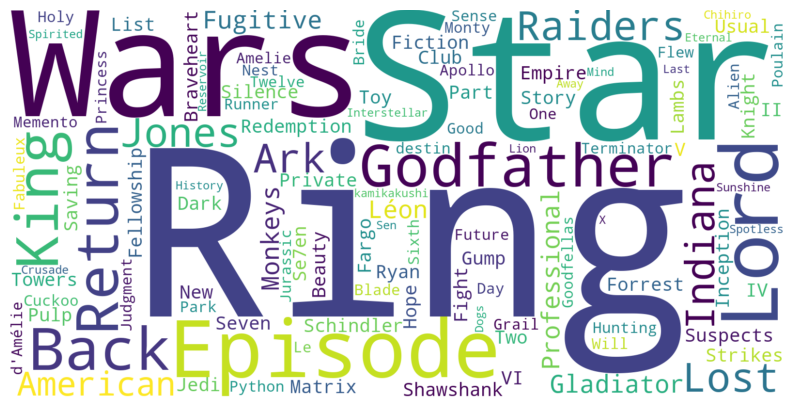

In [74]:
# Lista de Stopword
stop_words = set(STOPWORDS)

# Gerar a WordCloud
wordcloud_titulo_rating2 = WordCloud(stopwords = stop_words,
                             background_color = 'white' , 
                             width = 1600 , height = 800).generate(todos_titulos_rating)

# Plota a WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_titulo_rating2, interpolation='bilinear')
plt.axis('off')
plt.show()    

### Nuvem 2 - rating médio ponderado

In [75]:
# Selecionar os 300 primeiros valores únicos da coluna 'title'
top_titulos_rating = top_rating1['titulo_sem_ano'].unique()[:300]

# Filtra o DataFrame para selecionar as linhas correspondentes aos 300 primeiros valores únicos de 'title'
top_titulos_rating1 = top_rating1[top_rating1['titulo_sem_ano'].isin(top_titulos_rating) ] 

# Concatena todos os títulos em uma única string
todos_titulos_rating = ' '.join(top_titulos_rating1['titulo_sem_ano'])

print(f"Quantidade de palavras: {len(todos_titulos_rating)} , quantidade de palavras únicas:{len(set(todos_titulos_rating))}")

Quantidade de palavras: 6086 , quantidade de palavras únicas:74


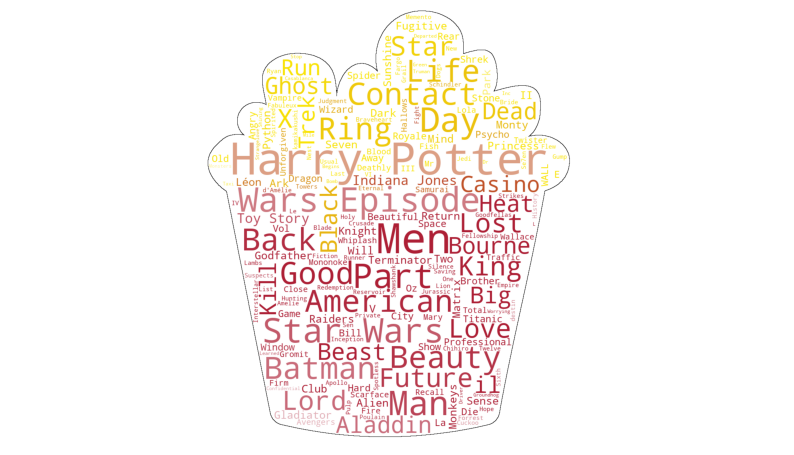

In [79]:
mascara_7 = np.array(Image.open("C:/0.Projetos/5.Sistema_de_Recomendacao_MovieLens_2/Imagens/Análise_Descritiva/Mascaras/mascara_7.png" ))

# Lista de Stopword
stop_words = set(STOPWORDS)
    
# Gerar a word_cloud
wordcloud_titulo_rating2 = WordCloud(stopwords = stop_words,
                             background_color = 'white', 
                             mask = mascara_7,
                             contour_color='black',
                             contour_width=1,
                             width = 1000 ,
                             height = 1000).generate(todos_titulos_rating)

imagem_colorida_rating = ImageColorGenerator(mascara_7)
wordcloud_titulo_rating2.recolor(color_func=imagem_colorida_rating)                             

# Plotar a WordCloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_titulo_rating2)
plt.axis('off')
plt.show()

# **7. Quais gêneros possuem mais avaliações? Quais gêneros possuem as maiores notas?**
Os gêneros que possuem os maiores rating médio ponderado são respectivamente: Crime, Aventura e Mistério, Sci-Fi e Horror.
<br>
Já os gêneros que possuem os maiores números de avaliações são respectivamente: Crime, Aventura, Mistério, Ação e Sci-Fi.
Observa-se que os dois resultados são muito semelhantes
<br><br>
Estes resultados também foram encontrados por [Lu e Waterman (2005)](https://www.semanticscholar.org/paper/Changing-Markets%2C-New-Technology%2C-and-Violent-An-of-Lu-Waterman/6ccc1dd4d6c1c82f151ef299a94c56401f3f0d06). Os pesquisadores descobriram que os gêneros cinematográficos "propensos à violência" (como "ação", "aventura", "ficção científica" e "terror") aumentaram consideravelmente sua prevalência entre os 20 filmes de maior bilheteria dos EUA no período de 1967 a 2004. <br><br>
**Uma possível explicação encontrada pelos pesquisadores é que estes gêneros aumentaram o uso de tecnologia nos filmes.** <br><br>
<b><mark>Vale ressaltar que o estudo foca nos filmes de maior bilheteria, cujo público alvo são os jovens, conforme será explicado nos próximos tópicos.</mark></b>  
<br>
Apesar do resultado não ser abrangente, ele ajuda a explicar o porquê destes gêneros terem as maiores notas e mais avaliações.


### Preparar a tabela

In [80]:
# Selecionar as colunas de interesse
tmp_movie = movies_treino_transformado[['movieId', 'genres_separado' ]]
tmp_ratings = ratings_treino_transformado[['movieId','Numero_de_Avaliacoes_por_Filme', 'rating_medio_ponderado']]

# Unir as tabelas 
generos_ratings1 = pd.merge(tmp_movie , tmp_ratings, on='movieId' , how='right' )
generos_ratings1.head(3)


movieId genres_separado  Numero_de_Avaliacoes_por_Filme  \
0       47         Mystery                            1567   
1       47         Mystery                            1567   
2       47         Mystery                            1567   

   rating_medio_ponderado  
0                3.286254  
1                3.286254  
2                3.286254

In [84]:
generos_ratings2 = generos_ratings1.drop_duplicates(subset=['genres_separado']).sort_values(by=['rating_medio_ponderado'], ascending= False)

In [ ]:
#del tmp_movie,tmp_ratings,generos_ratings1

### Tabela com gêneros dos filmes, nº de avaliações e rating médio ponderado

In [85]:
generos_ratings2

movieId     genres_separado  Numero_de_Avaliacoes_por_Filme  \
1811        318               Crime                            2948   
87100      4993           Adventure                            1915   
0            47             Mystery                            1567   
96999    109487              Sci-Fi                            1002   
56322      1258              Horror                             981   
8154        380              Action                            1243   
142052     1199             Fantasy                             457   
135401      913           Film-Noir                             382   
132160      745           Animation                             364   
263604   128360             Western                             286   
4759        319              Comedy                             207   
1567        175               Drama                             140   
16830      1147         Documentary                              94   
267091   166024  (no genres listed)                              77   
133358      900             Musical                              92   
14390       662            Thriller                              74   
338360     1658             Romance                              63   
15602      1005            Children                              66   
661141     3339                 War                              19   

        rating_medio_ponderado  
1811                  3.888469  
87100                 3.446509  
0                     3.286254  
96999                 3.084144  
56322                 2.992502  
8154                  2.693046  
142052                2.439924  
135401                2.318216  
132160                2.270124  
263604                1.914850  
4759                  1.708250  
1567                  1.258266  
16830                 1.153270  
267091                1.093831  
133358                1.068638  
14390                 0.826220  
338360                0.743696  
15602                 0.606369  
661141                0.444348

### Gráficos gêneros dos filmes, nº de avaliações e rating médio ponderado

In [109]:
# Criar uma figura e uma grade de subplots com 1 linha e 2 colunas
fig = sp.make_subplots(
    rows=1, cols=2, 
    subplot_titles=(
        'Gêneros com maior rating médio ponderado',
        'Gêneros com maior número de avaliações'
    ),
    horizontal_spacing=0.2,  # Aumentar o espaçamento horizontal entre os subplots
    vertical_spacing=0.02  # Espaçamento vertical entre os subplots
)

# Primeiro gráfico: rating médio ponderado
fig.add_trace(go.Bar(
    x=generos_ratings2['rating_medio_ponderado'],
    y=generos_ratings2['genres_separado'],
    orientation='h',
    text=[f'{x:.2f}' for x in generos_ratings2['rating_medio_ponderado']],
    textposition='outside',
    marker=dict(color='#03647A')
), row=1, col=1)

# Segundo gráfico: número de avaliações por filme
fig.add_trace(go.Bar(
    x=generos_ratings2['Numero_de_Avaliacoes_por_Filme'],
    y=generos_ratings2['genres_separado'],
    orientation='h',
    text=[f'{x:.0f}' for x in generos_ratings2['Numero_de_Avaliacoes_por_Filme']],
    textposition='outside',
    marker=dict(color='#03647A')
), row=1, col=2)

# Atualizar layout dos gráficos
fig.update_layout(
    height=450,  # Ajustar a altura da figura
    width=900,
    showlegend=False,
    plot_bgcolor='white',
    margin=dict(t=50, b=50, l=50, r=50),  # Ajustar as margens
)

# Atualizar layout do primeiro subplot
fig.update_xaxes(title_text='Rating Médio (Ponderado)', row=1, col=1, fixedrange=True)
fig.update_yaxes(title_text='Gêneros de Filme', row=1, col=1, tickfont=dict(size=12, family='Arial, bold', weight='bold'),fixedrange=True)
fig.update_yaxes(autorange="reversed", row=1, col=1,fixedrange=True)  # Inverter a ordem dos gêneros

# Atualizar layout do segundo subplot
fig.update_xaxes(title_text='Número de Avaliações por Filme', row=1, col=2, fixedrange=True)
fig.update_yaxes(title_text='Gêneros de Filme', row=1, col=2, tickfont=dict(size=12, family='Arial, bold',weight='bold'), fixedrange=True)
fig.update_yaxes(autorange="reversed", row=1, col=2, fixedrange=True)  # Inverter a ordem dos gêneros

# Configurar para desativar completamente o menu superior
fig.show(config={'displayModeBar': False}, renderer="notebook_connected")


In [110]:
# Salvar o gráfico como um arquivo HTML
import plotly.io as pio
pio.write_html(fig, file='Ranking_Generos_de_Filme.html', auto_open=True, config={'displayModeBar':False})


<!-- Aqui você pode colar o conteúdo do arquivo grafico_rating_contagem.html -->
<!-- Por exemplo, o conteúdo abaixo é um exemplo reduzido -->
<!--<iframe src="https://catarinaaguiar3.github.io/Projeto_Sistema_de_Recomendacao_MovieLens/Imagens/Analise_Descritiva/Q.7/Ranking_Generos_de_Filme.html" width="950" height="500"></iframe>-->
<!--<iframe src="https://catarinaaguiar3.github.io/Projeto_Sistema_de_Recomendacao_MovieLens/Imagens/Analise_Descritiva/Q.7/Ranking_Generos_de_Filme.html" width="150%" height="500px" frameborder="0" scrolling="auto"></iframe>-->

# **8. De quais anos são os filmes mais assistidos? E os mais bem avaliados?**
Os filmes mais assistidos são dos anos de 1995, 1994, 1999, 1996 e 2000, respectivamente. 
Até 1992, a quantidade de avalições por ano cresce timidamente. Entre 1993 e 2000, ela cresce de forma significativa. E, a partir dos anos 2001, a quantidade de avaliações começa a diminuir. 
<br><br>
Os filmes mais bem avaliados são os de 1977, 1972, 1975, 1994 e 1980, respectivamente. Ao olhar o gráfico, vemos que as avalições médias por ano aumentam por volta de 1920 e continuam crescendo, com algumas oscilações até 2001. 
<br><br>
Os filmes mais bem avaliados são mais antigos, possivelmente, são os filmes considerados clássicos. Já os filmes mais assistidos são um pouco mais novos, entre os anos 90 e início dos anos 2000.Esta foi a época que a internet se popularizou, o que facilitou a divulgação midiática dos filmes. 
<br><br>
Em ambos os gráficos, o número de avalições por ano e a contagem de filmes assistidos diminui a partir dos anos 2000. <br>
De acordo com o site [Britannica (history of film)](https://www.britannica.com/art/history-of-the-motion-picture/Transition-to-the-21st-century#ref284140),no final do século XX houve um aumento da capacidade de animação por computador e de câmeras de vídeo digitais,  isso fez com que **muitos cineastas utilizassem tais tecnologias para reduzir os custos de produção.**<br><br>
Além disso, nesta mesma época surgiu os DVDs, houve uma ampliação do acesso a TV a cabo e aos cinemas. Esses fatores contribuíram na internacionalização mercado cinematográfico. E com isso, os EUA ampliou seu domínio no cinema mundial. **No final da década de 90,  a produção de filmes nos EUA focou nos espectadores adolescentes, e de acordo com os críticos, isso diminuiu a qualidade dos filmes.**  
<br><br>
<b><mark>Portanto, existem dois fatores que podem explicar a queda nos gráficos a partir dos anos 2000: Aumento do uso de tecnologia gráfica nos filmes e foco no público jovem.</mark></b>
<br><br>
 

### Preparando as tabelas

Primeiro, vamos olhar as tabela que serão unidas

In [87]:
movies_treino_transformado.head(3)


movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  Ano_do_filme  \
0  Adventure|Animation|Children|Comedy|Fantasy          1995   
1                   Adventure|Children|Fantasy          1995   
2                               Comedy|Romance          1995   

     titulo_sem_ano genres_separado  
0         Toy Story       Adventure  
1           Jumanji       Adventure  
2  Grumpier Old Men          Comedy

In [88]:
ratings_treino_transformado.head(3)

userId  Numero_de_Avaliacoes_por_usuarios  movieId  \
0       5                                 43       47   
1     461                               1692       47   
2     751                                469       47   

   Numero_de_Avaliacoes_por_Filme  rating  rating_medio_simples  \
0                            1567     5.0              4.057754   
1                            1567     4.5              4.057754   
2                            1567     3.0              4.057754   

   rating_medio_ponderado  
0                3.286254  
1                3.286254  
2                3.286254

Vamos unir as tabelas

In [89]:
# Unir as tabela e selecionar as colunas de interesse
ano_filme_rating = pd.merge(movies_treino_transformado[['movieId','title','Ano_do_filme']], 
                            ratings_treino_transformado[['movieId', 'rating_medio_ponderado']], 
                            on="movieId", how="inner")
ano_filme_rating.head()                             

movieId             title  Ano_do_filme  rating_medio_ponderado
0        1  Toy Story (1995)          1995                3.264437
1        1  Toy Story (1995)          1995                3.264437
2        1  Toy Story (1995)          1995                3.264437
3        1  Toy Story (1995)          1995                3.264437
4        1  Toy Story (1995)          1995                3.264437

Agora, vamos remover as linhas cujo "Ano_do_filme" é igual a -1, pois são as observações em que não foi possível extrair o ano do filme.

In [90]:
# Remover linhas onde a coluna 'Ano_do_filme' tem valor -1
ano_filme_rating1 = ano_filme_rating.loc[ano_filme_rating['Ano_do_filme'] != -1]  

Faremos a contagem de avaliações por ano do filme.

In [91]:
# Fazer a contagem
contagem_movies = ano_filme_rating1[['Ano_do_filme']].value_counts(ascending=False).reset_index()
contagem_movies.head()

Ano_do_filme  count
0          1995  45559
1          1994  39641
2          1999  35463
3          1996  33980
4          2000  30310

Será criada a coluna ratin_medio_por_ano

In [92]:
# Agrupar os dados pela coluna 'Ano_do_filme' e calcular a média da coluna 'rating_medio_ponderado'
rating_medio_por_ano1 = ano_filme_rating1.groupby('Ano_do_filme')['rating_medio_ponderado'].mean().reset_index()

# Renomear a coluna de média para 'rating_medio_por_ano'
rating_medio_por_ano1 = rating_medio_por_ano1.rename(columns={'rating_medio_ponderado': 'rating_medio_por_ano'})
rating_medio_por_ano1.head()

Ano_do_filme  rating_medio_por_ano
0          1878              0.098156
1          1887              0.035130
2          1895              0.133113
3          1896              0.112191
4          1897              0.084134

**A seguir temos a tabela final**

In [93]:
# Unir as tabelas 
movies_ratings = pd.merge(rating_medio_por_ano1, contagem_movies, on="Ano_do_filme", how='inner' )
movies_ratings 

Ano_do_filme  rating_medio_por_ano  count
0            1878              0.098156      1
1            1887              0.035130      2
2            1895              0.133113      8
3            1896              0.112191      8
4            1897              0.084134      3
..            ...                   ...    ...
123          2019              0.917894   5966
124          2020              0.448593   2484
125          2021              0.420438   2104
126          2022              0.421568   1477
127          2023              0.184443    225

[128 rows x 3 columns]

#### Tabela com a contagem dos filmes mais assistidos
Vamos criar a tabela com os filmes mais assistidos.

In [94]:
movies_ratings_count = movies_ratings.sort_values(by='count',ascending=False)
movies_ratings_count1 = movies_ratings_count.head(5)
movies_ratings_count1.head()

Ano_do_filme  rating_medio_por_ano  count
99           1995              2.075816  45559
98           1994              2.255304  39641
103          1999              2.071166  35463
100          1996              1.742998  33980
104          2000              1.819669  30310

#### Tabela dos filmes com as maiores avaliações

In [95]:
movies_ratings_top = movies_ratings.sort_values(by='rating_medio_por_ano',ascending=False)
movies_ratings_top1 = movies_ratings_top.head(5)
movies_ratings_top1.head()

Ano_do_filme  rating_medio_por_ano  count
81          1977              2.413250   4823
76          1972              2.335413   3452
79          1975              2.311737   5111
98          1994              2.255304  39641
84          1980              2.200814   7491

### Gráfico

In [117]:
# Ordenando por ano
movies_ratings = movies_ratings.sort_values('Ano_do_filme')

# Dados para o gráfico de rating médio por ano
line_rating = go.Scatter(
    x=movies_ratings['Ano_do_filme'],
    y=movies_ratings['rating_medio_por_ano'],
    mode='lines+markers',
    name='Rating Médio',
    line=dict(color='#006868', width=2),
    marker=dict(size=8, color='#006868'),
)

# Destacar os 5 maiores anos de rating médio
top_5_years_rating = movies_ratings.nlargest(5, 'rating_medio_por_ano')
highlighted_points_rating = go.Scatter(
    x=top_5_years_rating['Ano_do_filme'],
    y=top_5_years_rating['rating_medio_por_ano'],
    mode='markers',
    name='Top 5 Anos',
    marker=dict(size=12, color='gold', symbol='star', line=dict(color='black', width=2)),
    showlegend=False,
)

# Dados para o gráfico de contagem por ano
line_count = go.Scatter(
    x=movies_ratings['Ano_do_filme'],
    y=movies_ratings['count'],
    mode='lines+markers',
    name='Contagem',
    line=dict(color='#7D01D6', width=2),
    marker=dict(size=8, color='#7D01D6')
)

# Destacar os 5 maiores anos de contagem
top_5_years_count = movies_ratings.nlargest(5, 'count')
highlighted_points_count = go.Scatter(
    x=top_5_years_count['Ano_do_filme'],
    y=top_5_years_count['count'],
    mode='markers',
    name='Top 5 Anos',
    marker=dict(size=12, color='gold', symbol='star', line=dict(color='black', width=2)),
    showlegend=False,
)

# Criar figuras e subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1,
                    subplot_titles=('Ano dos Filmes com as maiores avaliações', 'Ano dos Filmes mais assitidos'))
fig.add_trace(line_rating, row=1, col=1)
fig.add_trace(highlighted_points_rating, row=1, col=1)
fig.add_trace(line_count, row=2, col=1)
fig.add_trace(highlighted_points_count, row=2, col=1)

# Atualizar layout do subplot de Rating Médio por Ano
fig.update_xaxes(#title_text='Ano do Filme', 
                 tickangle=360, 
                 tickmode='linear', tick0=movies_ratings['Ano_do_filme'].min(), 
                 dtick=5, range=[movies_ratings['Ano_do_filme'].min(), movies_ratings['Ano_do_filme'].max()], row=1, col=1,
                 showgrid=True,gridcolor='rgba(0,0,0,0.1)',fixedrange=True  )
fig.update_yaxes(title_text='Rating Médio por ano', row=1, col=1,showgrid=True,gridcolor='rgba(0,0,0,0.1)',fixedrange=True  )


# Atualizar layout do subplot de Contagem por Ano
fig.update_xaxes(title_text='Ano do Filme', tickangle=360, tickmode='linear',
                 tick0=movies_ratings['Ano_do_filme'].min(), dtick=5, range=[movies_ratings['Ano_do_filme'].min(), 
                 movies_ratings['Ano_do_filme'].max()], row=2, col=1,tickfont=dict(size=10),      
                 showgrid=True,gridcolor='rgba(0,0,0,0.1)',fixedrange=True )
fig.update_yaxes(title_text='Contagem', row=2, col=1,showgrid=True,gridcolor='rgba(0,0,0,0.1)',fixedrange=True  )

# Atualizar layout da figura geral
fig.update_layout(
    #title='Ano dos Filmes com as maiores avaliações e mais assistidos',
    title_font=dict(family='Arial', size=24, color='black', weight='bold'),
    width=1100,  # Definindo a largura da figura para 1500 pixels
    plot_bgcolor='white',
    #hovermode='x',
    margin=dict(l=50, r=50, t=50, b=50),
)

# Configurar para desativar completamente o menu superior
fig.show(config={'displayModeBar': False}, renderer="notebook_connected")


In [118]:
# Salvar o gráfico como um arquivo HTML
pio.write_html(fig, file='Ano_dos_Filmes_com_as_maiores_avaliacoes_e_mais_assistidos.html',config={'displayModeBar': False}, auto_open=True)

<!-- Colar o Gráfico interativo em HTML -->
<!--<iframe src="C:/0.Projetos/5.Sistema_de_Recomendacao_MovieLens_2/Ano_dos_Filmes_com_as_maiores_avaliacoes_e_mais_assistidos.html" width="1100" height="600"></iframe>-->
<!--<iframe src="https://catarinaaguiar3.github.io/Projeto_Sistema_de_Recomendacao_MovieLens/Imagens/Analise_Descritiva/Q.8/Ano_dos_Filmes_com_as_maiores_avaliacoes_e_mais_assistidos.html" width="150%" height="500px" frameborder="0" scrolling="auto"></iframe>-->

# **Insights**

## **1.	Os usuários podem estar insatisfeitos com as recomendações do site**
A nota média dada pelo usuário (rating) foi de 3,52 (tópico 2) e essa média diminui conforme o usuário faz mais avaliações (tópicos 3 e 4). Além disso, o número de avaliações por usuário é baixo , a maioria faz 15 avaliações (tópico 3). Estes resultados, podem ser reflexo de uma insatisfação com as recomendações. <br><br>
Seria interessante a MovieLens investigar o comportamento destes usuários para melhorar as recomendações e aumentar a retenção
Para isso, o site poderia:
<ul>
    <li><b>Analisar o número de avaliações vs média (rating) ao longo do tempo</b>: Isto seria interessante para entender se existe um padrão temporal no uso do site MovieLens. Exemplo: por quanto tempo um usuário utiliza ativamente o site?</li> 
    <li><b>Fazer segmentações:</b> o MovieLens poderia segmentar os usuários por idade e gênero para descobrir como as notas dadas variam em cada grupo e assim, pensar em recomendações personalizadas para cada segmento de usuário.</li>
</ul>
<br>
Espera-se que após estas análises, o MovieLens melhore a média de ratings e aumente o número de avaliações por usuário.

## **2. Gêneros de destaque**
Os gêneros de filme Crime, Aventura e Mistério possuem as maiores notas e os maiores números de avaliações (tópico 7). Para empresas como a Netflix, esta é uma informação relevante para decidir em quais gêneros ela deve investir na hora de produzir um filme.

## **3. Explorar diferentes de nichos**

#### **1. Nicho: Filmes dos anos 90 – 2000**
Os filmes mais avaliados são do final da década de 90 e início dos anos 2000, principalmente dos gêneros Ação, Comédia e Crime (tópico 5)

#### **2. Nicho: Filmes clássicos**
Os filmes com as maiores avaliações são das décadas de 70 a 90, nos gêneros comédia, drama e crime (tópico 6). Em toda a análise, o gênero drama se destacou apenas neste nicho. Assim, se empresas como a Netflix buscam adquirir direitos autorais de dramas, devem considerar filmes clássicos.

#### **3. Sagas**
Apesar das sagas não aparecem no ranking dos filmes mais avaliados e com as maiores notas, as nuvens de palavras dos tópicos 4 e 5 mostram que as sagas ganham destaque quando consideradas em conjunto. Portanto, filmes de sagas podem ser um nicho interessante para aquisição de direitos autorais por plataformas de streaming.

#### **4. Nicho Jovem**
Conforme explicado no tópico 7, filmes propensos a violência (Crime, Aventura e Mistério) e que usam mais tecnologia,  chamam atenção do público jovem. 

#### **5. Nicho pessoas mais velhas**
O tópico 8 revela que a partir dos anos 2000 a média de avaliações por ano caiu, possivelmente devido à mudança de foco para o público jovem e ao uso excessivo de computação gráfica nos filmes. Em contraste com o nicho 4, este poderia se concentrar em filmes com menos efeitos visuais e que atendam a um público mais maduro, como filmes independentes.
<br>

> **OBS:** O dataset não tem informações sobre os usuários, isso limitou um pouco uma análise mais profunda. Se estas informações estivessem disponíveis, seria interessante analisar a relação de cada nicho de filme com os diferentes perfis de clientes/usuários.
